# Data Mining CS 619, Spring 2018 - Eleonora Renz

### Week 9 - Chapter 8

## Beating CAPTCHAs with Neural Networks

It should be noted that our CAPTCHAs will be a little
easier than those used on the web today.
Our CAPTCHA-busting algorithm will make the following assumptions.
First, the word will be a whole and valid four-character English word (in
fact, we use the same dictionary for creating and busting CAPTCHAs).
Second, the word will only contain uppercase letters. No symbols,
numbers, or spaces will be used.

Our goal will be to create a program that can recover the word from images. To do
this, we will use four steps:

1. Break the image into individual letters.
2. Classify each individual letter.
3. Recombine the letters to form a word.
4. Rank words with a dictionary to try to fix errors.

#### Drawing basic CAPTCHAs
Our goal here is to draw an image with a word on it, along with a shear transform.

In this function, we create a new image using L for the format, which means black-andwhite
pixels only, and create an instance of the ImageDraw class. This allows us to draw on
this image using PIL. We then load the font, draw the text, and perform a scikit-image
shear transform on it.
You can get

In [1]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from skimage import transform as tf

In [2]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    """Takes a word and a shear value (which is normally between 0 and 0.5) 
       to return an image in a NumPy array format."""
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype("Coval-Black.otf", 22) 
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    # Apply scale
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey))
    return image

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


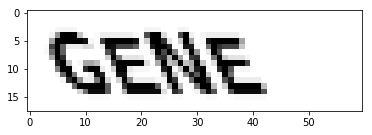

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


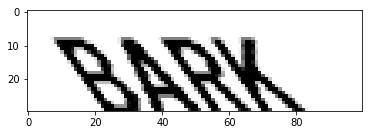

In [4]:
image = create_captcha("BARK", shear=0.8, scale=1.0)
plt.imshow(image, cmap='Greys')

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


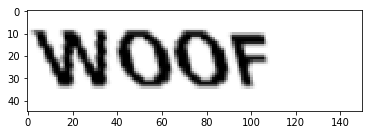

In [5]:
image = create_captcha("WOOF", shear=0.25, scale=1.5)
plt.imshow(image, cmap='Greys')

In [6]:
from skimage.measure import label, regionprops

def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
        if len(subimages) == 0:
            # No subimages found, so return the entire image
            return [image,]
        return subimages

In [7]:
# Get subimages from example CAPTCHA
subimages = segment_image(image)

#### Creating a training dataset

In [8]:
from sklearn.utils import check_random_state

random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)
scale_values = np.arange(0.5, 1.5, 0.1)

def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    # We use 30,30 as the image size to ensure we get all the text in the image
    return create_captcha(letter, shear=shear, size=(30,30), scale=scale), letters.index(letter)

The target for this image is: 11


C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


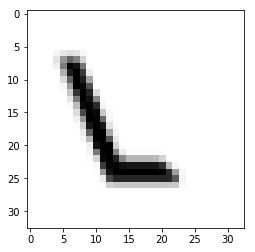

In [9]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")
print("The target for this image is: {0}".format(target))

In [10]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20,20)) for sample in dataset])
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [12]:
y = y.todense()
x = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Training and classifying

In [14]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14)
clf.fit(x_train, y_train)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=14, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [15]:
y_pred = clf.predict(x_test)

In [16]:
from sklearn.metrics import f1_score

f1_score(y_pred=y_pred, y_true=y_test, average='macro')

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9615384615384616

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         5
          4       1.00      1.00      1.00         4
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         2
          7       1.00      1.00      1.00         8
          8       1.00      1.00      1.00         5
          9       1.00      1.00      1.00         5
         10       1.00      1.00      1.00         7
         11       1.00      1.00      1.00         7
         12       0.00      0.00      0.00         0
         13       1.00      1.00      1.00         1
         14       1.00      1.00      1.00         4
         15       1.00      1.00      1.00         5
         16       1.00      1.00      1.00         2
         17       1.00      1.00      1.00   

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Predicting words p.184

In [18]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    # Preform the same transformations we did for our training data
    dataset = np.array([np.resize(subimage,(20,20)) for subimage in subimages])
    x_test = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
    # Use predict_proba and argmax to get the most likely prediction
    y_pred = neural_network.predict_proba(x_test)
    predictions = np.argmax(y_pred, axis=1)
    
    # Convert predictions to letters
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


I


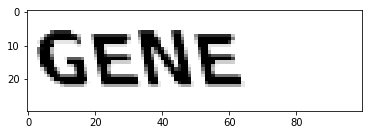

In [19]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, clf))
plt.imshow(captcha, cmap="Greys")

In [20]:
def test_prediction(word, net, shear=0.2, scale=1):
    """PReforms prediction"""
    captcha = create_captcha(word, shear=shear, scale=scale, size=(len(word) * 25, 30))
    prediction = predict_captcha(captcha, net)
    return word == prediction, word, prediction

In [21]:
from nltk.corpus import words

valid_words = set([word.upper() for word in words.words() if len(word) == 4])

num_correct = 0 
num_incorrect = 0 
for word in valid_words: 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=shear, scale=scale)
    if correct: 
        num_correct += 1 
    else: 
        num_incorrect += 1
print("Number correct is {0}".format(num_correct)) 
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 0
Number incorrect is 4995


In [22]:
def evaluation_versus_shear(shear_value):
    num_correct = 0
    num_incorrect = 0
    for word in valid_words:
        scale = random_state.choice(scale_values)
        correct, word, prediction = test_prediction(word, clf, shear = shear_value, scale=scale)
        if correct:
            num_correct += 1
        else:
            num_incorrect += 1
    return num_correct/(num_correct+num_incorrect)

In [23]:
scores = [evaluation_versus_shear(shear) for shear in shear_values]

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [24]:
from nltk.metrics import edit_distance

steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [25]:
def compute_distance(prediction, word):
    len_word = min(len(prediction), len(word))
    return len_word - sum([prediction[i] == word[i] for i in range(len_word)])

#### Putting it all together

In [26]:
from operator import itemgetter

def improved_prediction(word, net, dictionary, shear=0.2, scale=1.0):
    captcha = create_captcha(word, shear=shear, scale=scale)
    prediction = predict_captcha(captcha, net)
    
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [27]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = improved_prediction(word, clf, valid_words, shear=shear, scale=scale)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
num_correct = 3037
num_incorrect = 2476
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\Owner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 3037
Number incorrect is 2476
